# **Classify reviews by varying the size of the training set**

This code classify reviews into different classes
This is done following several steps



1.   Read the file that contains the reviews that have been labelled manually. This is a csv file 
2.   Read the file that containes the features that have been already extracted from these reviews (extracted using a pretrained LLM)
3. convert the 2 csv into data frames then arraws of : features (X) and labels (y)
4. Divide the dataset into different splits with always the same 92 examples in the test set:
  * the whole dataset contains 276 reviews
  * the training set will vary from 92 to 184
5. Train a classifier for each set and save the results
6. Show the results into graphs (curves)

# **How to use the code**
The code was run on google colab, each file used must be put in one's peronal google drive.

As of today, google colab can only access to the drive of the person that is running the code, hence by mounting google colab on the drive, only the current user's drive is visible to colab

Therefore, for executing the code, the folder named code_hexamind should be put directly in one's drive.

# **Prerequisites**

**Importing libraries**

In [ ]:
# install for multi label classification
!pip install -q scikit-multilearn # ! is for google colab, remove it if code run on local

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np


#Libraries for classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, hamming_loss, classification_report, f1_score

from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

**Mounting the drive**

In [ ]:
# mounting the drive
drive.mount('/content/drive')

Mounted at /content/drive


**Defining the names**

In [ ]:
# specifying the working directory
main_Folder="/content/drive/My Drive/Review_analysis/"
data_Folder = main_Folder+'data/'
# folder of training
csv_data=data_Folder+'data.csv' 
csv_labels=data_Folder+'20230220_selected_df.csv' 
#csv_indices = data_Folder+ 'with_embed.csv'

# **Reading the csv**
- First the data, i.e. the feature embeding for each review

In [ ]:
df_data = pd.read_csv (csv_data, header=None, sep=",")
print(df_data.shape)

(649, 768)


In [ ]:
# uncomment if you want to see the data frame
# df_data

- Then the labels

In [ ]:
df_label = pd.read_csv (csv_labels)
df_label.shape

(276, 34)

In [ ]:
# uncomment if you want to see the data frame
#df_label

- Then the indices

In [ ]:
indices= df_label.iloc[:,0]
indices.shape

(276,)

In [ ]:
# uncomment if you want to see the indices
# indices

Now, we need to have the feature vectors from df_data that concern the labels in df_labels. This information is contained in indices computed previously

In [ ]:
df_data  = df_data.iloc[indices,:]

In [ ]:
df_labels= df_label.iloc[:,-4:]

In [ ]:
print("size of the data ", df_data.shape, "size of the labels ", df_labels.shape)

size of the data  (276, 768) size of the labels  (276, 4)


# **Check the number of classes in the whole dataset**

In [ ]:
print("The number of unique rows, i.e. unique classes for which the reviews belong is:\n",np.unique(df_labels, axis=0).shape[0])

The number of unique rows, i.e. unique classes for which the reviews belong is:
 15


# **Preparing the data for training the head**

First, learn about the distribuation of the data

Note that `random_state` is important, as the value of 41, allows us to have all the classes in the test set

In [ ]:
X= df_data
y= df_labels
X_train_all, X_test, y_train_all, y_test = train_test_split( X, y, test_size=0.33, random_state=41) 

**Check the number of classes in the test set**

In [ ]:
print("The number of unique rows, i.e. unique classes for which the reviews belong is:\n",np.unique(y_test, axis=0).shape[0])

The number of unique rows, i.e. unique classes for which the reviews belong is:
 15


In [ ]:
print("data train size : ", X_train_all.shape, "label train size : ", y_train_all.shape, 
      "data test size : ", X_test.shape, "label test size : ", y_test.shape )

data train size :  (184, 768) label train size :  (184, 4) data test size :  (92, 768) label test size :  (92, 4)


# **Training a SVC classifier for multilabel classification**
We will be using the multi label classification of Sickit learn.
Note that it is most often used with an SVM classifier but can be used with a deep network.
In this pipeline we use SVM with three methods and report the results.
For more inofrmation, one can refer to :
http://scikit.ml/

In [ ]:
def plot_metrics(size_training, F1, Accuracy, Hamming_loss):
  text= ['Size of the training set is: '+str(size_training)]

  plt.figure(figsize=(18, 3))

  plt.subplot(131)
  plt.plot(size_training, F1)
  plt.scatter(size_training, F1)
  plt.xlabel('Size of the training')
  plt.ylabel('F1 Score')

  plt.subplot(132)
  plt.plot(size_training, Accuracy)
  plt.scatter(size_training, Accuracy)
  plt.xlabel('Size of the training')
  plt.ylabel('Accuracy')

  plt.subplot(133)
  plt.plot(size_training, Hamming_loss)
  plt.scatter(size_training, Hamming_loss)
  plt.xlabel('Size of the training')
  plt.ylabel('Hamming')

  plt.suptitle('Plotting of the metrics according to the size of the training set')
  plt.show()

  print(text)

**First, classify using binary relevance**

In [ ]:
classifier = BinaryRelevance(
    classifier = SVC(kernel='rbf'),
    require_dense = [False, True])

In [ ]:
# Vary the training size and train
Accuracy_binary=[]
F1_binary=[]
Hamming_loss_binary=[]
size_training=[]

for vary_size in range(50, 100, 1):
  X_train, X_test_useless, y_train, y_test_useless = train_test_split( X_train_all, y_train_all, test_size=1-vary_size/100, random_state=43)
  classifier.fit(X_train, y_train)
  predictions = classifier.predict(X_test)
  # print the result

  ''' print('********* results for size of the training ', X_train.shape[0], '***********' )
  print('percentage of the test is ', vary_size )
  print('Accuracy = ', accuracy_score(y_test,predictions))
  print('F1 score is ',f1_score(y_test, predictions, average="micro"))
  print('Hamming Loss is ', hamming_loss(y_test, predictions), '\n')
  '''
  Accuracy_binary.append(accuracy_score(y_test,predictions))
  F1_binary.append(f1_score(y_test, predictions, average="micro"))
  Hamming_loss_binary.append(hamming_loss(y_test, predictions))
  size_training.append(X_train.shape[0])

# last iteration is for the whole dataset; as the data split cannont take a 0 percentage for the test set
classifier.fit(X_train_all, y_train_all)
predictions = classifier.predict(X_test)
# print the result

Accuracy_binary.append(accuracy_score(y_test,predictions))
F1_binary.append(f1_score(y_test, predictions, average="micro"))
Hamming_loss_binary.append(hamming_loss(y_test, predictions))
size_training.append(X_train_all.shape[0])

### **Plot the impact of varying the size of the training set**

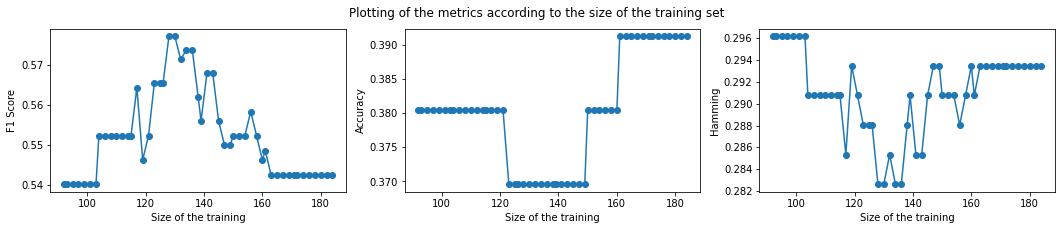

['Size of the training set is: [92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182, 184]']


In [ ]:
plot_metrics(size_training, F1_binary, Accuracy_binary, Hamming_loss_binary)

**Second, classify using a classifier chain**

In [ ]:
classifier = ClassifierChain(
    classifier = SVC(kernel='rbf'),
    require_dense = [False, True])

In [ ]:
# Vary the training size and train
Accuracy_Chain=[]
F1_Chain=[]
Hamming_loss_Chain=[]
size_training=[]

for vary_size in range(50, 100, 1):
  X_train, X_test_useless, y_train, y_test_useless = train_test_split( X_train_all, y_train_all, test_size=1-vary_size/100, random_state=43)
  classifier.fit(X_train, y_train)
  predictions = classifier.predict(X_test)
  # print the result

  ''' print('********* results for size of the training ', X_train.shape[0], '***********' )
  print('percentage of the test is ', vary_size )
  print('Accuracy = ', accuracy_score(y_test,predictions))
  print('F1 score is ',f1_score(y_test, predictions, average="micro"))
  print('Hamming Loss is ', hamming_loss(y_test, predictions), '\n')
  '''
  Accuracy_Chain.append(accuracy_score(y_test,predictions))
  F1_Chain.append(f1_score(y_test, predictions, average="micro"))
  Hamming_loss_Chain.append(hamming_loss(y_test, predictions))
  size_training.append(X_train.shape[0])

# last iteration is for the whole dataset; as the data split cannont take a 0 percentage for the test set
classifier.fit(X_train_all, y_train_all)
predictions = classifier.predict(X_test)
# print the result

Accuracy_Chain.append(accuracy_score(y_test,predictions))
F1_Chain.append(f1_score(y_test, predictions, average="micro"))
Hamming_loss_Chain.append(hamming_loss(y_test, predictions))
size_training.append(X_train_all.shape[0])

### **Plot the impact of varying the size of the training set**

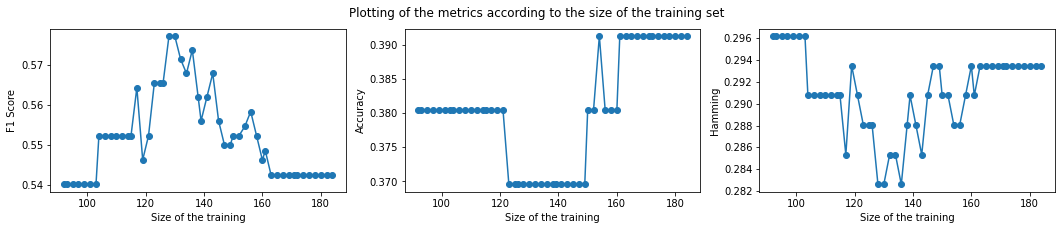

['Size of the training set is: [92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182, 184]']


In [ ]:
plot_metrics(size_training, F1_Chain, Accuracy_Chain, Hamming_loss_Chain)

**Third, classify using a label powerset**

In [ ]:
classifier = LabelPowerset(
    classifier = SVC(kernel='sigmoid'),
    require_dense = [False, True])

In [ ]:
# Vary the training size and train
Accuracy_Powerset=[]
F1_Powerset=[]
Hamming_loss_Powerset=[]
size_training=[]

for vary_size in range(50, 100, 1):
  X_train, X_test_useless, y_train, y_test_useless = train_test_split( X_train_all, y_train_all, test_size=1-vary_size/100, random_state=43)
  classifier.fit(X_train, y_train)
  predictions = classifier.predict(X_test)
  # print the result

  ''' print('********* results for size of the training ', X_train.shape[0], '***********' )
  print('percentage of the test is ', vary_size )
  print('Accuracy = ', accuracy_score(y_test,predictions))
  print('F1 score is ',f1_score(y_test, predictions, average="micro"))
  print('Hamming Loss is ', hamming_loss(y_test, predictions), '\n')
  '''
  Accuracy_Powerset.append(accuracy_score(y_test,predictions))
  F1_Powerset.append(f1_score(y_test, predictions, average="micro"))
  Hamming_loss_Powerset.append(hamming_loss(y_test, predictions))
  size_training.append(X_train.shape[0])

# last iteration is for the whole dataset; as the data split cannont take a 0 percentage for the test set
classifier.fit(X_train_all, y_train_all)
predictions = classifier.predict(X_test)
# print the result

Accuracy_Powerset.append(accuracy_score(y_test,predictions))
F1_Powerset.append(f1_score(y_test, predictions, average="micro"))
Hamming_loss_Powerset.append(hamming_loss(y_test, predictions))
size_training.append(X_train_all.shape[0])

### **Plot the impact of varying the size of the training set**

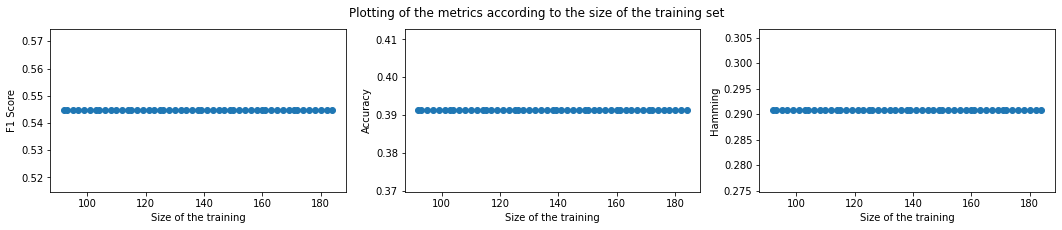

['Size of the training set is: [92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182, 184]']


In [ ]:
plot_metrics(size_training, F1_Powerset, Accuracy_Powerset, Hamming_loss_Powerset)